# Data exploration of Grocery Prices in Jamaica

Source: https://www.data.gov.jm/dataset/consumer-grocery-prices

Timespan about 2012-2017

## Setup imports

In [1]:
%matplotlib inline

import os, sys
import shutil
import tempfile
import glob
import re
import time
import datetime
import copy
import pickle
import hashlib
import logging
import warnings
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)

In [2]:
# log level
logging.basicConfig(
    stream=sys.stdout,
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO)

logger = logging.getLogger("notebook")
logger.setLevel(logging.DEBUG)

# disable font not found warnings
logging.getLogger('matplotlib.font_manager').disabled = True

## Read data

In [102]:
# Use Jupyter magic to retain variable in this notebook
%env DATA_DIRECTORY=data

data_dir = os.environ.get("DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
dataset_regex = "Grocery_Price_Survey_201?_Q?.csv"
pickle_filename = "Grocery_data.pkl"

env: DATA_DIRECTORY=data


In [4]:
from pathlib import Path

csv_files = list(Path(data_dir).glob(dataset_regex))
len(csv_files)

21

In [5]:
df_list = []

for f in csv_files:
    df_list.append(pd.read_csv(f, parse_dates=['SurveyDate'],
                               dtype={'Outlet_Name': 'str', 'Town': 'str',
                                      'Parish': 'str', 'Item':'str', 'Price': np.float64},
                               na_values=['N\\A']))

df = pd.concat(df_list, ignore_index=True, axis=0)

In [6]:
df.dtypes

OutletID                int64
SurveyDate     datetime64[ns]
Outlet_Name            object
Town                   object
Parish                 object
Item                   object
ItemID                  int64
Price                 float64
dtype: object

In [7]:
df.Price.isnull().sum()

np.int64(97746)

In [8]:
df.shape

(606454, 8)

In [9]:
# Drop null prices
df = df.dropna()
# Drop non positive prices
df = df[df.Price > 0.]
df.shape

(369563, 8)

In [10]:
def clean_names(column):
    """
    Strip backslashes and leading and trailing spaces
    """
    # dump multiple spaces
    temp = column.str.replace("\\","")
    temp = temp.str.replace("  "," ")
    temp = temp.str.replace("   "," ")
    temp = temp.str.strip(' -')
    temp = temp.str.title()
    temp = temp.str.replace("'S", "'s")
    temp = temp.str.replace("St.Thomas", "St. Thomas") 

    return temp

In [11]:
for name in df.columns[[2,3,4,5]]:
    df[name] = clean_names(df[name])

In [12]:
df.sort_values('SurveyDate')

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
517899,154,2012-01-05,Super Plus,Four Paths,Clarendon,Sweetened Condensed Milk [Tx] Nestle 395 G,9149452,150.00
520231,89,2012-01-05,Joong,Portmore,St. Catherine,Powdered Laundry Detergent [Tx] Ariel 400 G,7843653,163.99
520232,89,2012-01-05,Joong,Portmore,St. Catherine,Insect Spray [Tx] Baygon 260 Ml,6443742,274.00
520233,89,2012-01-05,Joong,Portmore,St. Catherine,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,368.00
520234,89,2012-01-05,Joong,Portmore,St. Catherine,Pepper [Tx] Betapac 110 G,7643928,191.00
...,...,...,...,...,...,...,...,...
101898,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Matches [Tx] Any 1 Pk,7281823,50.00
101896,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Mosquito Destroyer [Tx] Vape 6 Coils,7381961,80.00
101895,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Mosquito Destroyer [Tx] Bug Off 6 Coils,7344661,65.00
101904,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Laundry Soap Bar [Tx] Bomber 140 G,6644181,55.00


In [13]:
df.columns

Index(['OutletID', 'SurveyDate', 'Outlet_Name', 'Town', 'Parish', 'Item',
       'ItemID', 'Price'],
      dtype='object')

In [14]:
# OutletID mapping to Outlet_Name
for c in df.columns[[0,2]]:
    print(c, len(df[c].unique()))

OutletID 135
Outlet_Name 113


In [15]:
# ItemID mapping to Item
for c in df.columns[[6,5]]:
    print(c, len(df[c].unique()))

ItemID 231
Item 231


Looks like Item mapping is one-to-one, but Outlet_Name is one-to-many. This is probably due to different location so no action needed.

In [16]:
supermarkets = sorted(df.Outlet_Name.unique())

In [17]:
# TBD clean-up with Sashara

supermarkets

["A J's Supermarket",
 "Abc Supermarket - Brown's Town",
 'Ambersley',
 'Any Money Supermarket',
 "Auntie Maur's Supermarket",
 'Basic Needs Supermarket',
 'Bay City Supermarket- Montego Bay',
 'Best Buy Mini Mart',
 'Best Value Supermarket',
 'Best Way Wholesale',
 'Better & Better Supermarket- Annotto Bay',
 'Brooklyn (Clock Tower Plaza)',
 'Brooklyn (Twin Gates Plaza)',
 "Brown's Town Supermarket",
 'Bull Head Supermarket',
 "Campbell's Supermarket",
 'Cari Home Supermarket',
 'Century Supermarket',
 'Cheries Supermarket',
 'Cherish Supermaket',
 'Classic Super Shop',
 "Consumers' Meat Plus",
 'D & Y Supermarket',
 'Daily Foods Supermarket',
 "Dotty's Grocery",
 'Empire Supermarket (Portmore Pines)',
 'Empire Supermarket- Cross Roads',
 'Empire Supermarket-Liguanea',
 'Exquisite Grocery',
 'Family Choice',
 'Family Pride',
 'Fedlin Supermarket',
 "Floyd's Supermarket",
 'Food Palace Wholesale',
 'Friendship Grocery',
 "Gayle's Grocery",
 'General Food Supermarket',
 "Graham's",
 'Gr

In [18]:
# TODO check with Sashara
towns = sorted(df.Town.unique())
len(towns)

55

In [19]:
# TODO Kingston is missing here...
parishes = sorted(df.Parish.unique())
len(parishes)

13

In [20]:
df.head()

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
1,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Batteries [Tx] Panasonic C,11649990,260.0
2,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Cabbage (Green) [Nt] Local 1 Kg,3548621,170.0
3,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Batteries [Tx] Duracell Aa,11646291,250.0
5,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Water Crackers National 143 G,5049392,71.0
7,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Dark Sugar (Pre-Packaged) [Nt] Sunshine Crysta...,11751122,171.0


In [21]:
# TODO what nt and tx means?? strip these?

items = sorted(df.Item.unique())
len(items)

231

<Axes: xlabel='Price', ylabel='Count'>

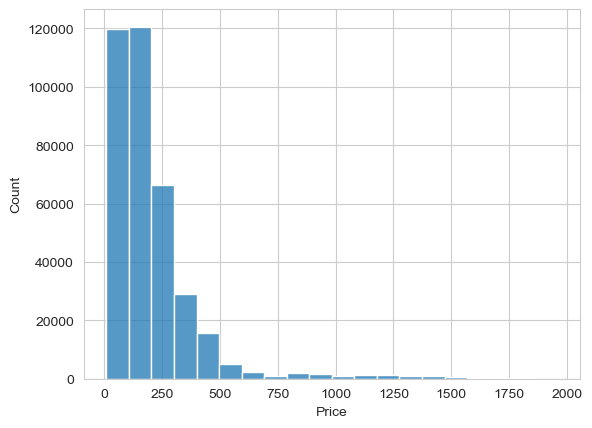

In [26]:
sns.histplot(df.Price, bins=20)

In [103]:
# Save a checkpoint
with open(pickle_filename, 'wb') as f:
    pickle.dump(df, f)

In [104]:
# Load checkpoint
with open(pickle_filename, 'rb') as f:
    df = pickle.load(f)

### Sample analysis

Whole Chicken (Grade A, Frozen) [Nt] Best Dressed 1 Kg
ID: 10243821

In [109]:
id = 10243821
df_chicken = df[df.ItemID == id]
df_chicken.shape

(5267, 8)

#### Monthly median price development

<Axes: xlabel='SurveyDate'>

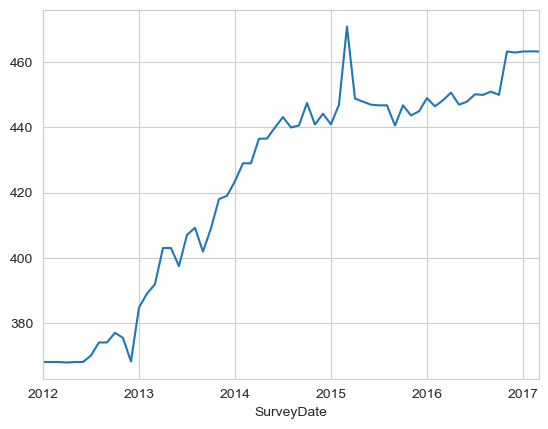

In [110]:
df_chicken.set_index('SurveyDate').groupby(pd.Grouper(freq='ME')).Price.median().plot()

#### Cheapest place to buy?

In [125]:
latest_year = max(df_chicken.SurveyDate.dt.year)

In [126]:
# Take latest prices for each OutletID
df_prices = chicken[chicken.SurveyDate.dt.year == latest_year].groupby('OutletID').last().reset_index()

In [127]:
df_prices.head()

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
0,19,2017-03-09,A J's Supermarket,Spanish Town,St. Catherine,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,463.40
1,35,2017-03-09,Brooklyn (Twin Gates Plaza),Half-Way Tree,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,498.96
2,47,2017-03-09,D & Y Supermarket,Savanna-La-Mar,Westmoreland,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,463.30
3,58,2017-03-09,Family Pride,Havendale,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,474.01
4,60,2017-03-09,Fedlin Supermarket,Santa Cruz,St. Elizabeth,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,492.80


In [128]:
# 10 cheapest
df_prices.groupby('Town').min().sort_values('Price')[:10]

,OutletID,SurveyDate,Outlet_Name,Parish,Item,ItemID,Price
Town,,,,,,,
Portmore,89,2017-01-05,Independence City Super Market - Portmore,St. Catherine,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,418.00
Cambridge,192,2017-03-09,Zhen's Wholesale,St. James,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,418.00
Washington Boulevard,100,2017-03-09,Lee's Food Fair,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,418.77
Montego Bay,72,2017-03-09,Best Value Supermarket,St. James,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,421.80
Port Antonio,94,2017-03-09,Kamal's,Portland,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,426.80
Brown's Town,591,2017-03-09,Brown's Town Supermarket,St. Ann,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,429.00
Lucea,117,2017-03-09,Cheries Supermarket,Hanover,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,429.00
Savanna-La-Mar,47,2017-03-09,D & Y Supermarket,Westmoreland,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,433.16
Christiana,92,2017-02-09,Jr's,Manchester,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,440.00


In [124]:
# 10 most expensive
df_prices.groupby('Town').max().sort_values('Price', ascending=False)[:10]

,OutletID,SurveyDate,Outlet_Name,Parish,Item,ItemID,Price
Town,,,,,,,
Junction,247,2017-03-09,Shopper's Fair,St. Elizabeth,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,522.83
May Pen,246,2017-03-09,Shopper's Fair,Clarendon,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,515.19
Constant Spring,181,2017-01-05,Public Supermarket,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,498.99
Half-Way Tree,222,2017-03-09,Brooklyn (Twin Gates Plaza),St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,498.96
Esher,218,2017-03-09,Gayle's Grocery,St. Mary,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,495.00
Santa Cruz,190,2017-03-09,Fedlin Supermarket,St. Elizabeth,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,492.80
Spanish Town,694,2017-03-09,Shopper's Fair,St. Catherine,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,485.01
Buff Bay,243,2017-03-09,Shopper's Pride,Portland,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,484.00
Lucea,466,2017-03-09,Naing Supermarket,Hanover,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,484.00
